In [4]:
import sys
sys.path.append("..")

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, top_k_accuracy_score
from sklearn.preprocessing import normalize

import torch
import tqdm
import umap

### Load embeddings

In [2]:
codings_audio_val = torch.load("../../michal-oleszak-research/embeddings/2022-07-21_audio_encoding_validate.pt")
codings_video_val = torch.load("../../michal-oleszak-research/embeddings/2022-07-21_video_encoding_validate.pt")
with open("../../michal-oleszak-research/embeddings/2022-07-21_labels_validate.txt", "r") as f:
    labels_val = f.read().splitlines()
    
codings_audio_test = torch.load("../../michal-oleszak-research/embeddings/2022-07-21_audio_encoding_test.pt")
codings_video_test = torch.load("../../michal-oleszak-research/embeddings/2022-07-21_video_encoding_test.pt")
with open("../../michal-oleszak-research/embeddings/2022-07-21_labels_test.txt", "r") as f:
    labels_test = f.read().splitlines()

### Calc the gap

In [5]:
# normalize to unit norm
video_norm_val = normalize(codings_video_val, norm="l2")
audio_norm_val = normalize(codings_audio_val, norm="l2")
video_norm_test = normalize(codings_video_test, norm="l2")
audio_norm_test = normalize(codings_audio_test, norm="l2")

# get original gap
video_center_val = video_norm_val.mean(axis=0)
audio_center_val = audio_norm_val.mean(axis=0)
gap_original_val = video_center_val - audio_center_val

video_center_test = video_norm_test.mean(axis=0)
audio_center_test = audio_norm_test.mean(axis=0)
gap_original_test = video_center_test - audio_center_test

# UMAP viz

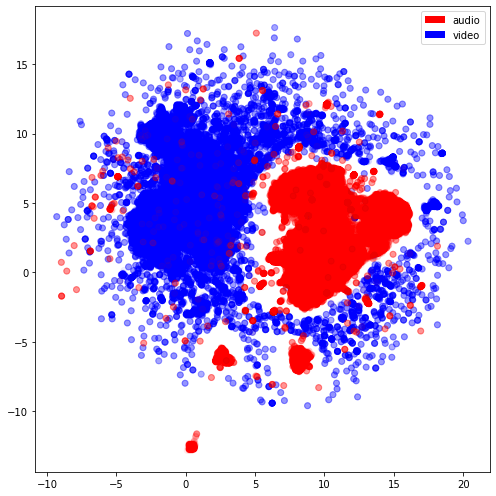

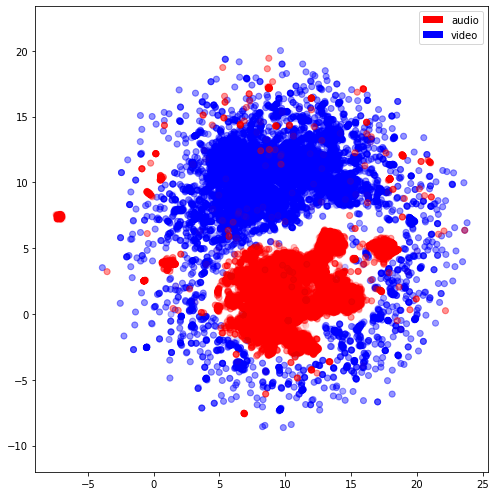

In [127]:
codings_lists = [[video_norm_val, audio_norm_val], [video_norm_test, audio_norm_test]]

for codings_list in codings_lists:

    dataset_size = codings_list[0].shape[0]
    
    umap_reducer = umap.UMAP()
    umap_embedding = umap_reducer.fit_transform(np.vstack(codings_list))
    
    plt.figure(figsize=(7, 7))
    plt.scatter(
        umap_embedding[:, 0],
        umap_embedding[:, 1],
        c=["blue"] * dataset_size + ["red"] * dataset_size,
        alpha=0.05,
    )
    plt.gca().set_aspect('equal', 'datalim')
    plt.legend(handles=[Patch(facecolor="red", label='audio'), Patch(facecolor="blue", label='video')])
    plt.tight_layout()
    plt.show()

# t-SNE viz

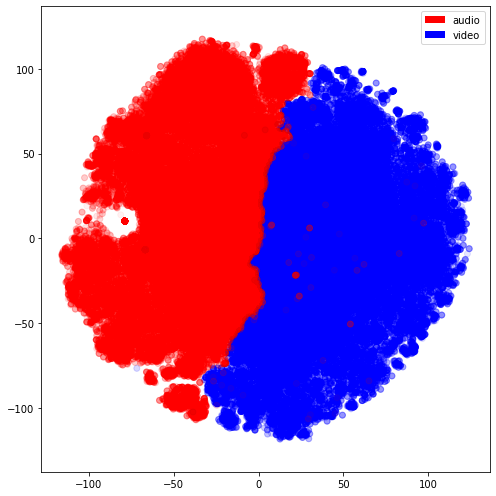

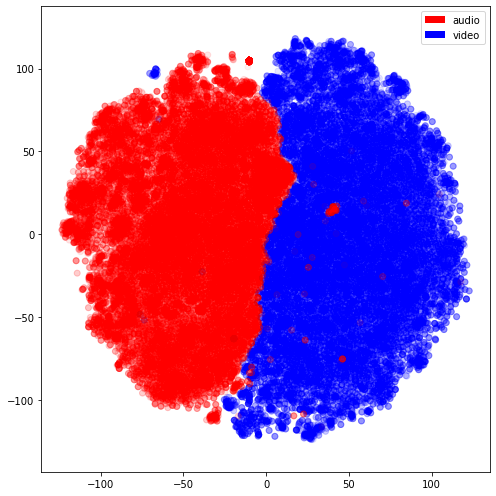

In [128]:
codings_lists = [[video_norm_val, audio_norm_val], [video_norm_test, audio_norm_test]]

for codings_list in codings_lists:

    dataset_size = codings_list[0].shape[0]

    tsne_reducer = TSNE(n_components=2, learning_rate='auto', init='random')
    tsne_embedding = tsne_reducer.fit_transform(np.vstack(codings_list))
    
    plt.figure(figsize=(7, 7))
    plt.scatter(
        tsne_embedding[:, 0],
        tsne_embedding[:, 1],
        c=["blue"] * dataset_size + ["red"] * dataset_size,
        alpha=0.05,
    )
    plt.gca().set_aspect('equal', 'datalim')
    plt.legend(handles=[Patch(facecolor="red", label='audio'), Patch(facecolor="blue", label='video')])
    plt.tight_layout()

# Embedding shift experiment

In [16]:
# bsz : batch size (number of positive pairs)
# d   : latent dim
# x   : Tensor, shape=[bsz, d]
#       latents for one side of positive pairs
# y   : Tensor, shape=[bsz, d]
#       latents for the other side of positive pairs

def align_loss(x, y, alpha=2):
    return (x - y).norm(p=2, dim=1).pow(alpha).mean()

def uniform_loss(x, t=2):
    return torch.pdist(x, p=2).pow(2).mul(-t).exp().mean().log()

def shift_embeddings(vid, aud, lambd, gap):
    video_shifted = normalize(vid - lambd * gap, norm="l2")
    audio_shifted = normalize(aud + lambd * gap, norm="l2")
    return video_shifted, audio_shifted
    
def get_gap(vid, aud):
    video_center = vid.mean(axis=0)
    audio_center = aud.mean(axis=0)
    gap = video_center - audio_center
    return np.linalg.norm(gap)

def eval_metrics(codings_val, labels_val, codings_test, labels_test):
    output = {}
    
    linreg = LogisticRegression(max_iter=1000)
    linreg.fit(codings_val, labels_val)
    preds = linreg.predict_proba(codings_test)
        
    output["acc"] = linreg.score(codings_test, labels_test)
    output["roc"] = roc_auc_score(pd.get_dummies(labels_test), preds)
    output["uniform_loss_vid"] = uniform_loss(torch.Tensor(codings_val[:10_000, :]))
#     output["uniform_loss_aud"] = uniform_loss(torch.Tensor(codings_val[:10_000, 128:]))
    
    return output

In [19]:
vid_orig_val = video_norm_val.copy()
aud_orig_val = audio_norm_val.copy()
gap_orig_val = np.linalg.norm(gap_original_val)

vid_orig_test = video_norm_test.copy()
aud_orig_test = audio_norm_test.copy()
gap_orig_test = np.linalg.norm(gap_original_test)

lambdas = np.arange(0., 1., 0.2)

In [20]:
results = []
for l in tqdm.tqdm(lambdas):
    v_shifted, a_shifted = shift_embeddings(vid_orig_val, aud_orig_val, l, gap_orig_val)
    v_shifted_test, a_shifted_test = shift_embeddings(vid_orig_test, aud_orig_test, l, gap_orig_test)
    gap = get_gap(v_shifted, a_shifted)
    gap_test = get_gap(v_shifted_test, a_shifted_test)

    regression_metrics = eval_metrics(
#         codings_val=np.hstack([v_shifted, a_shifted]),
        codings_val=v_shifted,
        labels_val=labels_val,
#         codings_test=np.hstack([v_shifted_test, a_shifted_test]),
        codings_test=v_shifted_test,
        labels_test=labels_test
    )
    
    results.append({
        "original_gap": gap_orig_val,
        "modified_gap": gap,
        "original_gap_test": gap_orig_test,
        "modified_gap_test": gap_test,
        "lambda": l,
        "acc": regression_metrics["acc"],
        "roc_auc": regression_metrics["roc"],
        "u_loss_vid": regression_metrics["uniform_loss_vid"],
#         "u_loss_aud": regression_metrics["uniform_loss_aud"],
    })
    
results_df = pd.DataFrame(results)

100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [20:18<00:00, 243.69s/it]


In [23]:
results_df

,original_gap,modified_gap,original_gap_test,modified_gap_test,lambda,acc,roc_auc,u_loss_vid
0,0.223568,0.223568,0.223541,0.223541,0.0,0.228615,0.920653,tensor(-3.7370)
1,0.223568,0.953188,0.223541,0.953269,0.2,0.229959,0.921288,tensor(-2.8925)
2,0.223568,1.446007,0.223541,1.446025,0.4,0.231180,0.922137,tensor(-1.7966)
3,0.223568,1.682532,0.223541,1.682543,0.6,0.230165,0.922237,tensor(-1.1091)
4,0.223568,1.800351,0.223541,1.800359,0.8,0.227641,0.921514,tensor(-0.7239)


In [14]:
results_df

,original_gap,modified_gap,original_gap_test,modified_gap_test,lambda,acc,roc_auc,u_loss_vid,u_loss_aud
0,0.223568,0.223568,0.223541,0.223541,0.0,0.236132,0.921903,tensor(-3.7370),tensor(-3.8236)
1,0.223568,0.953188,0.223541,0.953269,0.2,0.238861,0.923006,tensor(-2.8925),tensor(-3.0537)
2,0.223568,1.446007,0.223541,1.446025,0.4,0.245007,0.925280,tensor(-1.7966),tensor(-1.9113)
3,0.223568,1.682532,0.223541,1.682543,0.6,0.249575,0.926945,tensor(-1.1091),tensor(-1.1766)
4,0.223568,1.800351,0.223541,1.800359,0.8,0.251605,0.927524,tensor(-0.7239),tensor(-0.7646)


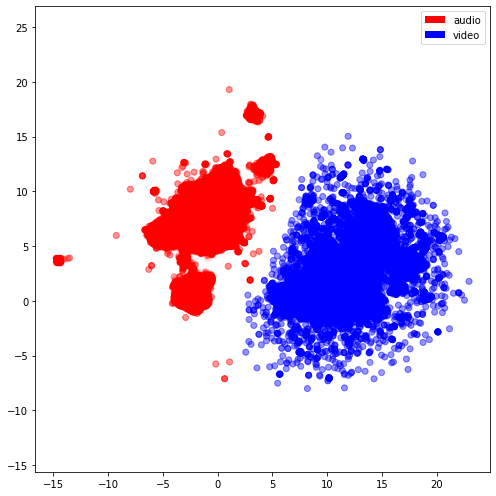

In [164]:
codings_list = [v_shifted, a_shifted]
dataset_size = codings_list[0].shape[0]

umap_reducer = umap.UMAP()
umap_embedding = umap_reducer.fit_transform(np.vstack(codings_list))

plt.figure(figsize=(7, 7))
plt.scatter(
    umap_embedding[:, 0],
    umap_embedding[:, 1],
    c=["blue"] * dataset_size + ["red"] * dataset_size,
    alpha=0.05,
)
plt.gca().set_aspect('equal', 'datalim')
plt.legend(handles=[Patch(facecolor="red", label='audio'), Patch(facecolor="blue", label='video')])
plt.tight_layout()